In [1]:
import matplotlib.pyplot as plt
import os, re, json, pickle,tqdm
import scipy.io
from collections import defaultdict
import numpy as np
import warnings, logging
warnings.filterwarnings('ignore')

In [15]:
root_path = '/opt/jinhanz/results/optimize_faithfulness_finer/bdd/xai_saliency_maps_fasterrcnn/optimization_human'

In [9]:
layers = ['backbone.res2.0.conv1','backbone.res2.0.conv2','backbone.res2.0.conv3','backbone.res2.1.conv1','backbone.res2.1.conv2','backbone.res2.1.conv3','backbone.res2.2.conv1','backbone.res2.2.conv2','backbone.res2.2.conv3','backbone.res3.0.conv1','backbone.res3.0.conv2','backbone.res3.0.conv3','backbone.res3.1.conv1','backbone.res3.1.conv2','backbone.res3.1.conv3','backbone.res3.2.conv1','backbone.res3.2.conv2','backbone.res3.2.conv3','backbone.res3.3.conv1','backbone.res3.3.conv2','backbone.res3.3.conv3','backbone.res4.0.conv1','backbone.res4.0.conv2','backbone.res4.0.conv3','backbone.res4.1.conv1','backbone.res4.1.conv2','backbone.res4.1.conv3','backbone.res4.2.conv1','backbone.res4.2.conv2','backbone.res4.2.conv3','backbone.res4.3.conv1','backbone.res4.3.conv2','backbone.res4.3.conv3','backbone.res4.4.conv1','backbone.res4.4.conv2','backbone.res4.4.conv3','backbone.res4.5.conv1','backbone.res4.5.conv2','backbone.res4.5.conv3','heads.pooler.level','heads.res5.0.conv1','heads.res5.0.conv2','heads.res5.0.conv3','heads.res5.1.conv1','heads.res5.1.conv2','heads.res5.1.conv3','heads.res5.2.conv1','heads.res5.2.conv2','heads.res5.2.conv3']

In [16]:
model = [m for m in ['faster','yolov5s'] if m in root_path][0]
dataset = [d for d in ['mscoco','_vehicle','_human'] if d in root_path][0].replace('_','')
# xai_method = [x for x in ['fullgradcamraw','odam'] if x in root_path][0]
# rescale_method = [r for r in ['bilinear','sigma2','sigma4'] if r in root_path][0]
is_act = True if f"_{model}_act_" in root_path else False

print(f"{model}_{dataset}_optimize_faithfulnee: {'Activation Map' if is_act else 'Feature Map'}")

skip_images = []
if model == 'faster':
    if dataset == 'mscoco':
        skip_images = ['book_472678','clock_164363','hair drier_178028','hair drier_239041', 'kite_405279', 'mouse_513688', 'toaster_232348', 'toaster_453302', 'toothbrush_218439', 'traffic light_453841']
    elif dataset == 'vehicle':
        skip_images = ['1007', '1023', '1028', '1041', '1079', '1108', '1121', '1127', '1170', '1201', '1253', '1258', '1272', '134', '1344', '1356', '210', '297', '321', '355', '383', '390', '406', '425', '485', '505', '52', '542', '634', '648', '711', '777', '784', '796', '797', '838', '848', '857', '899', '902', '953', '967', '969', '988', '99', '993']
    elif dataset == 'human':
        skip_images = ['2334', '1313', '1302', '2186', '1770', '1154', '1663', '186', '425', '875', '845', '829', '388', '748', '900', '1346', '1803', '1359', '1022', '97', '2203', '1066', '231', '1097', '488', '415', '2128', '2008', '2121', '2092', '2271', '1506', '1389', '1954', '2226', '670', '2161', '1041', '250', '1141', '348', '1063', '452', '601', '19', '1746', '1917', '1420', '1817', '270', '1398', '2040', '11', '1475', '897', '1805', '997', '1788']

faster_human_optimize_faithfulnee: Feature Map


In [19]:
best_sigmas_all = []
best_faithfulness_all = []
best_sigmas_by_layer = defaultdict(list)

faithfulness_all = defaultdict()
iAUC_all = defaultdict()
dAUC_all = defaultdict()

for dir in os.listdir(root_path):
    if not os.path.isdir(os.path.join(root_path,dir)): continue

    if model == 'faster':
        try:
            layer_name = re.findall(r'_[a-zA-Z0-9]+\.[a-zA-Z0-9\.]+_',dir)[0].replace('_','')
        except:
            continue
    elif model == 'yolov5s':
        try:
            layer_name = re.findall(r'_model_[a-zA-Z0-9_]+_act_',dir)[0][1:-1]
        except:
            continue

    faithfulness_layer = defaultdict(list)
    iAUC_layer = defaultdict(list)
    dAUC_layer = defaultdict(list)

    all_imgs = sorted(os.listdir(os.path.join(root_path,dir)))
    all_imgs = [f for f in all_imgs if '.json' in f]

    for img_idx, img_file in enumerate(all_imgs):
        try: # Check which iamge??
            file = json.load(open(os.path.join(root_path, dir, img_file),'r'))
        except:
            continue

        best_sigma = file['best_sigma']
        best_faithfulness = file['best_faithfulness']
        best_sigmas_all.append(best_sigma)
        best_faithfulness_all.append(best_faithfulness)
        best_sigmas_by_layer[layer_name].append(best_sigma)

        best_faithfulness_tmp = 0

        for s, step in file['attempts'].items():
            if step['faithfulness'] > best_faithfulness_tmp:
                best_faithfulness_tmp = step['faithfulness']
                iAUC_layer[img_file].append(step['iAUC'])
                dAUC_layer[img_file].append(step['dAUC'])
            else:
                iAUC_layer[img_file].append(iAUC_layer[img_file][-1])
                dAUC_layer[img_file].append(dAUC_layer[img_file][-1])
            faithfulness_layer[img_file].append(best_faithfulness_tmp)

    faithfulness_all[layer_name] = faithfulness_layer
    iAUC_all[layer_name] = iAUC_layer
    dAUC_all[layer_name] = dAUC_layer

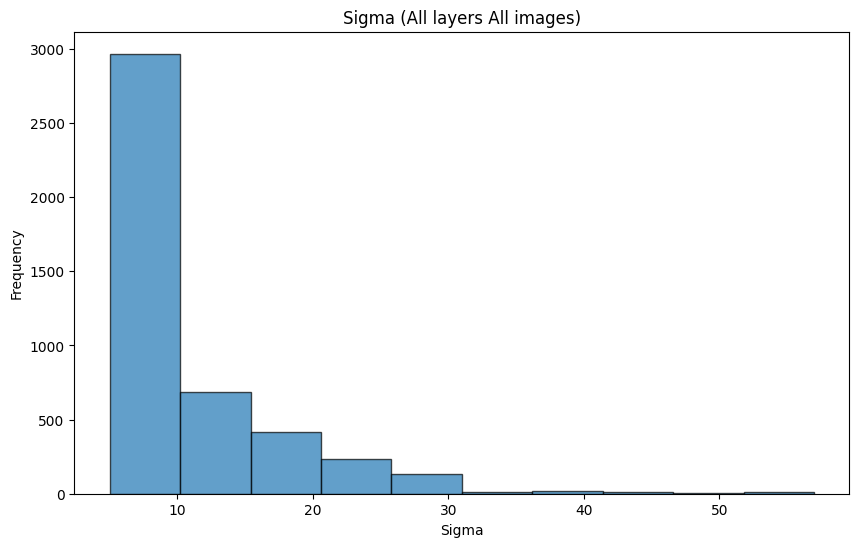

In [23]:
plt.figure(figsize=(10,6))
plt.hist(best_sigmas_all, bins=10, alpha=0.7, edgecolor='black')
plt.title('Sigma (All layers All images)')
plt.xlabel('Sigma')
plt.ylabel('Frequency')
plt.show()

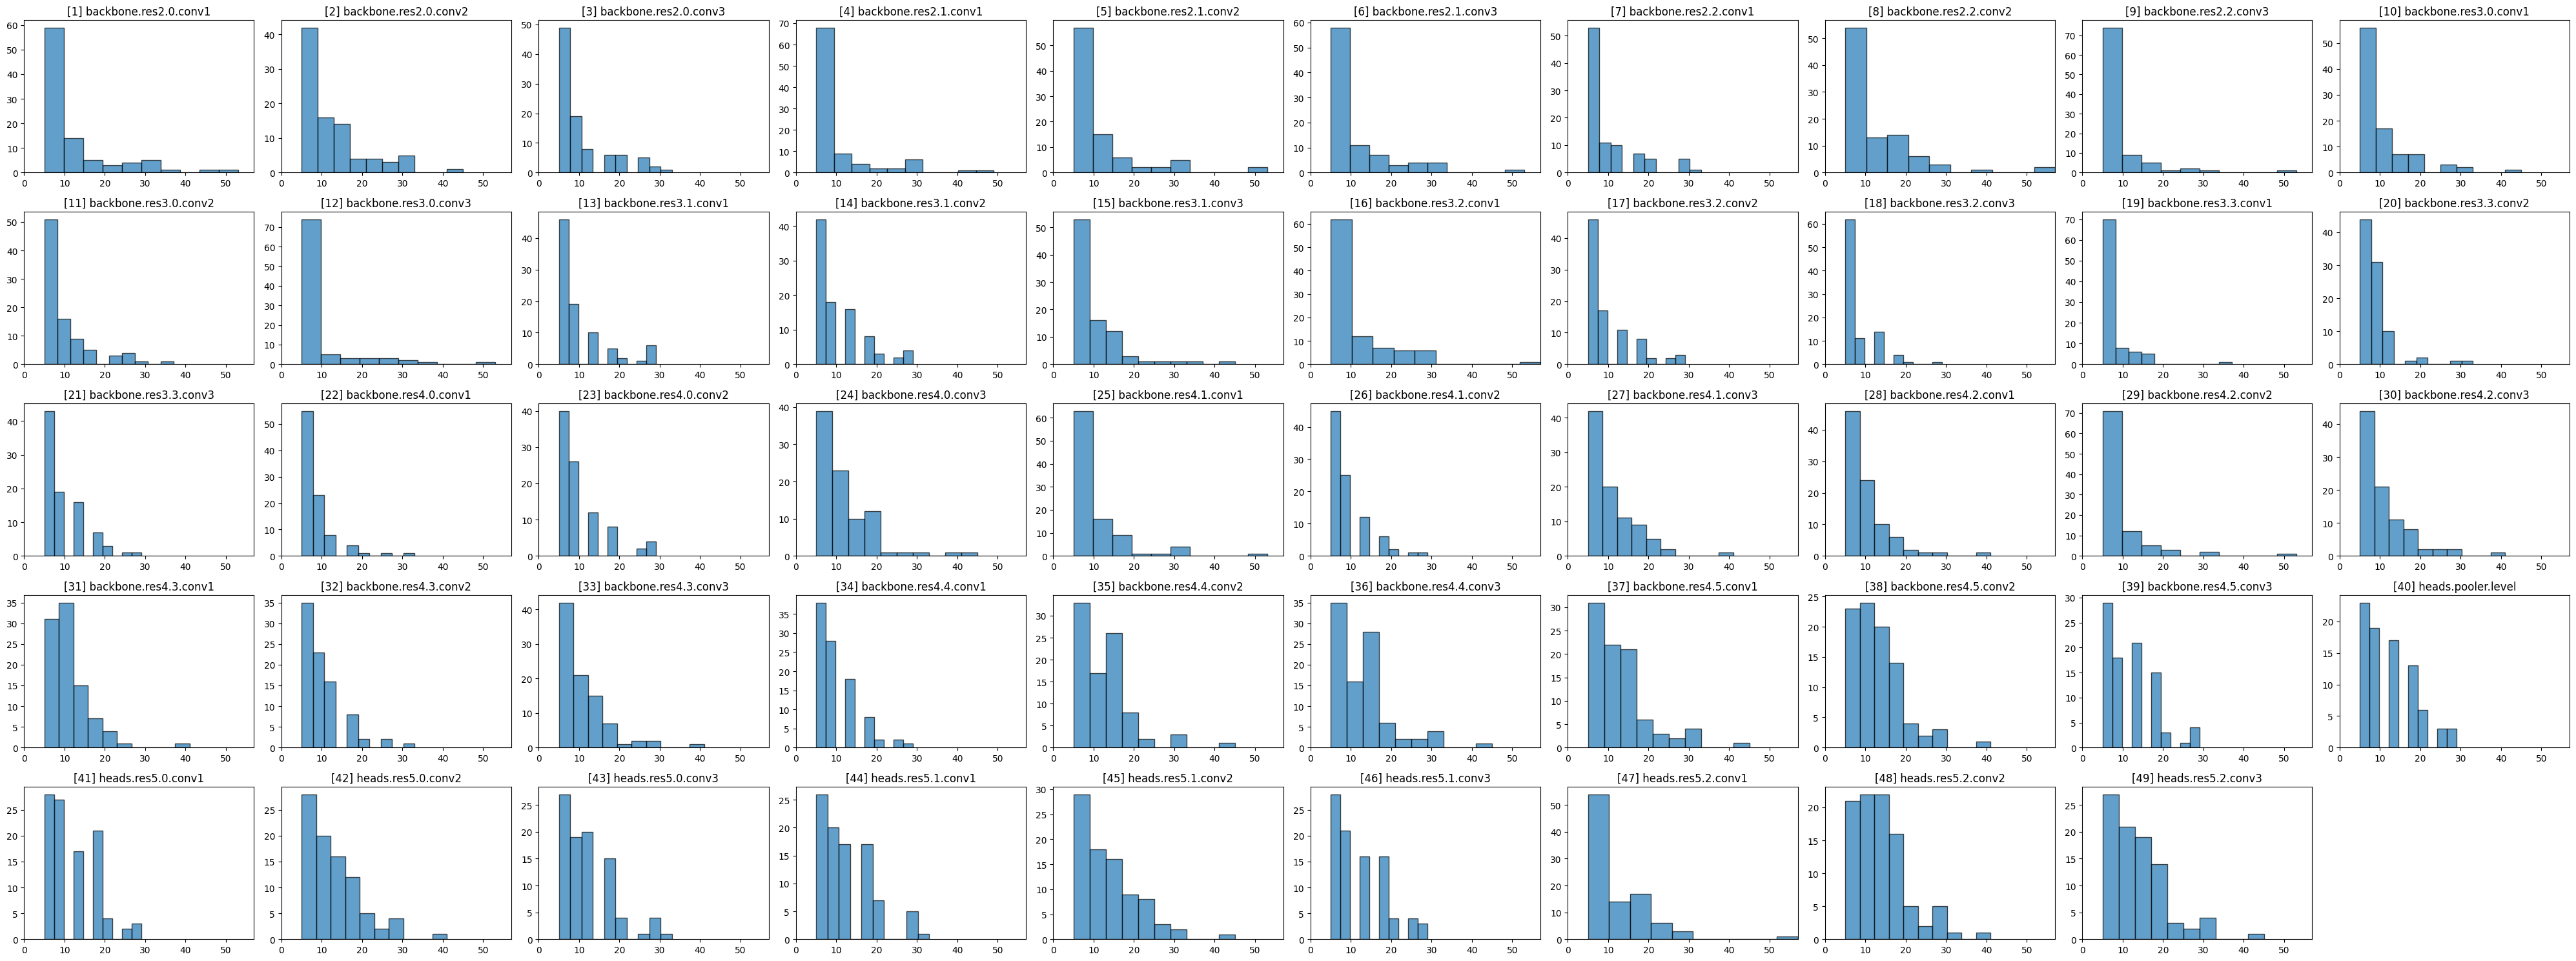

In [24]:
rows = 5
cols = 10
fig, axes = plt.subplots(rows,cols,figsize=(40,15))

layer_idx = 1

for i in range(rows):
    for j in range(cols):

        if layer_idx > len(layers) : continue

        layer = layers[layer_idx-1]
        
        axes[i,j].hist(best_sigmas_by_layer[layer], bins=10, alpha=0.7, edgecolor='black')

        axes[i,j].set_title(f"[{layer_idx}] {layer}")
        # axes[i,j].axis('off')
        layer_idx += 1

        # axes[i,j].set_xlabel('Value')
        axes[i,j].set_xlim([0,max(best_sigmas_all)])
        # axes[i,j].set_ylabel('Frequency')

for i in range(layer_idx, rows * cols + 1):
    fig.delaxes(axes.flatten()[i - 1])

# plt.title('Sigma (By layer)')
plt.tight_layout()
plt.show()

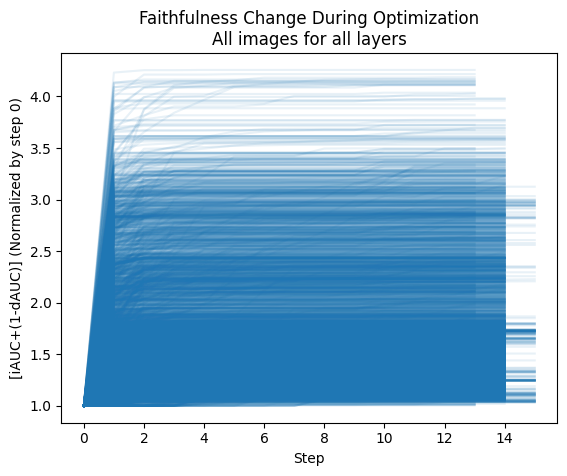

In [6]:
for l, faithfulness_layer in faithfulness_all.items():
    if l not in layers:continue
    for i, img in faithfulness_layer.items():
        plt.plot(np.asarray(img)/img[0],alpha=0.1,c='tab:blue')
plt.xlabel('Step')
plt.ylabel('[iAUC+(1-dAUC)] (Normalized by step 0)')
plt.title('Faithfulness Change During Optimization\nAll images for all layers')
plt.show()

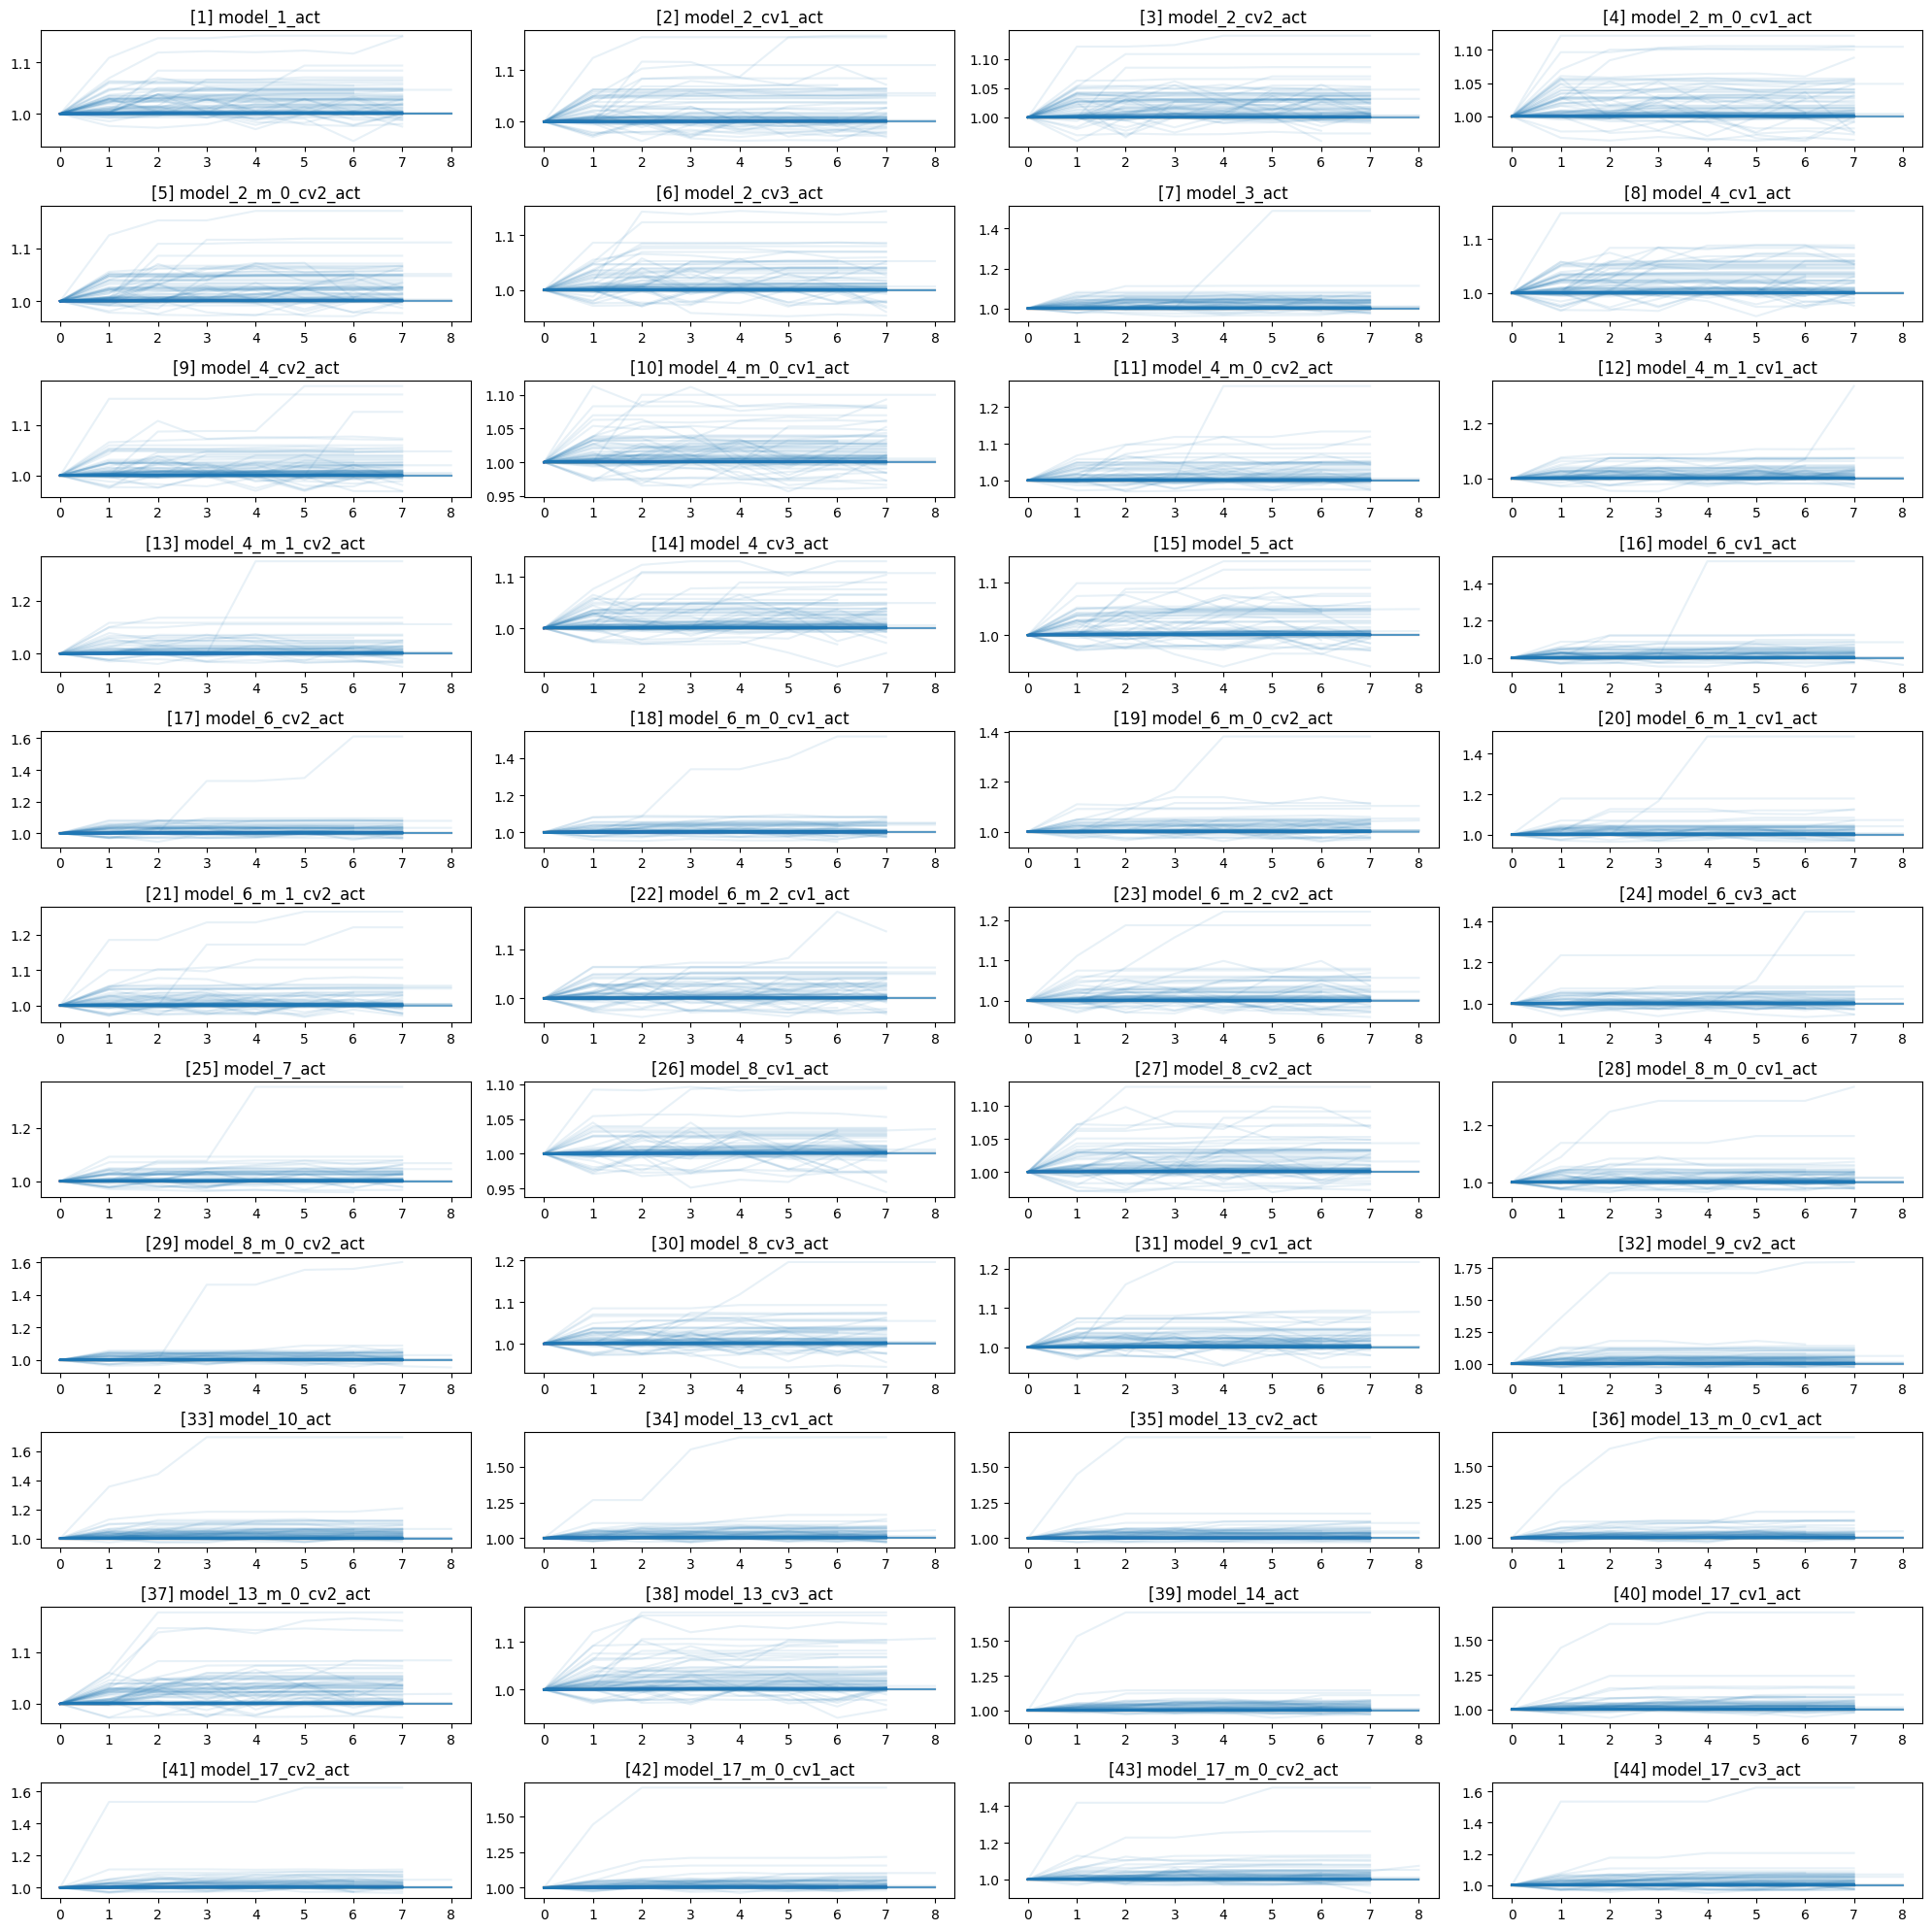

In [10]:
rows = 11
cols = 4
fig, axes = plt.subplots(rows,cols,figsize=(20,20))

layer_idx = 1

for i in range(rows):
    for j in range(cols):
        layer = layers[layer_idx-1]

        for img_idx,img in faithfulness_all[layer].items():
            axes[i,j].plot(np.asarray(img)/img[0],alpha=0.1,c='tab:blue')

        axes[i,j].set_title(f"[{layer_idx}] {layer}")
        # axes[i,j].axis('off')
        layer_idx += 1

        # axes[i,j].set_xlabel('Value')
        # axes[i,j].set_ylabel('Frequency')

    #Hide any unused axes in the current row
    for j in range(len(layers[i]), cols):
        fig.delaxes(axes[i, j])

# plt.title('Sigma (By layer)')
plt.tight_layout()
plt.show()

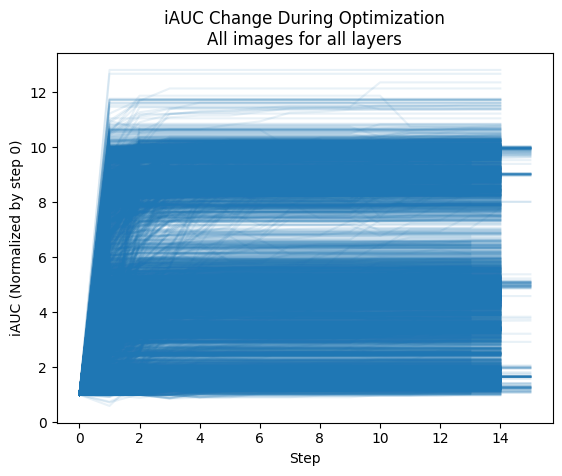

In [9]:
for l, faithfulness_layer in iAUC_all.items():
    if l not in layers:continue
    for i, img in faithfulness_layer.items():
        plt.plot(np.asarray(img)/img[0],alpha=0.1,c='tab:blue')
# plt.ylim([0,3])
plt.xlabel('Step')
plt.ylabel('iAUC (Normalized by step 0)')
plt.title('iAUC Change During Optimization\nAll images for all layers')
plt.show()

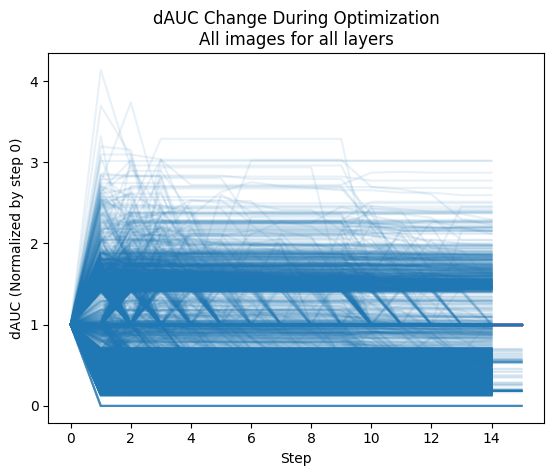

In [8]:
for l, faithfulness_layer in dAUC_all.items():
    if l not in layers:continue
    for i, img in faithfulness_layer.items():
        plt.plot(np.asarray(img)/img[0],alpha=0.1,c='tab:blue')
plt.xlabel('Step')
plt.ylabel('dAUC (Normalized by step 0)')
plt.title('dAUC Change During Optimization\nAll images for all layers')
plt.show()

# Faithfulness - Sigma Distribution

In [19]:
best_sigmas_all = []
best_faithfulness_all = []
best_sigmas_by_layer = defaultdict(list)

faithfulness_all = defaultdict()
sigma_all = defaultdict()

for dir in os.listdir(root_path):
    if not os.path.isdir(os.path.join(root_path,dir)): continue

    if model == 'faster':
        try:
            layer_name = re.findall(r'_[a-zA-Z0-9]+\.[a-zA-Z0-9\.]+_',dir)[0].replace('_','')
        except:
            continue
    elif model == 'yolov5s':
        try:
            layer_name = re.findall(r'_model_[a-zA-Z0-9_]+_act_',dir)[0][1:-1]
        except:
            continue

    faithfulness_layer = defaultdict(list)
    sigma_layer = defaultdict(list)

    all_imgs = sorted(os.listdir(os.path.join(root_path,dir)))
    all_imgs = [f for f in all_imgs if '.json' in f and any([target for target in included_imgs if target in f])]

    for img_idx, img_file in enumerate(all_imgs):
        file = json.load(open(os.path.join(root_path, dir, img_file),'r'))

        faithfulness_all_steps = [step['faithfulness'] for s,step in file['attempts'].items()]

        if all(x == 1 for x in faithfulness_all_steps): continue # zero iAUC all steps. excluded in analysis

        sigma_all_steps = [step['sigma'] for s,step in file['attempts'].items()]

        faithfulness_layer[img_file] = faithfulness_all_steps
        sigma_layer[img_file] = sigma_all_steps

    faithfulness_all[layer_name] = faithfulness_layer
    sigma_all[layer_name] = sigma_layer

### Relative

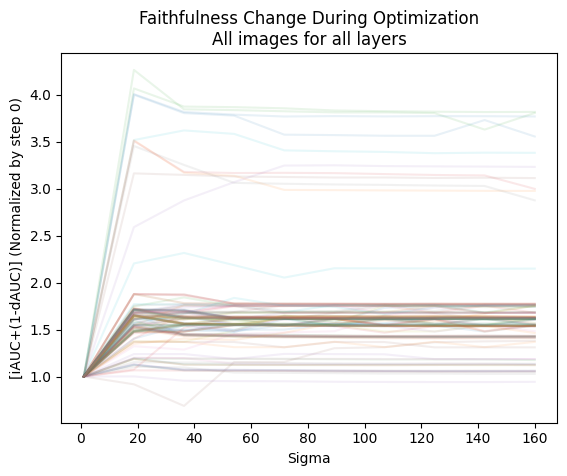

In [20]:
# Faithfulness Relative Value Distribution

for l, faithfulness_layer in faithfulness_all.items():
    if l not in layers:continue
    for i, img in faithfulness_layer.items():
        plt.plot(np.asarray(sigma_all[l][i]), np.asarray(img)/img[0],alpha=0.1)
plt.xlabel('Sigma')
plt.ylabel('[iAUC+(1-dAUC)] (Normalized by step 0)')
plt.title('Faithfulness Change During Optimization\nAll images for all layers')
plt.show()

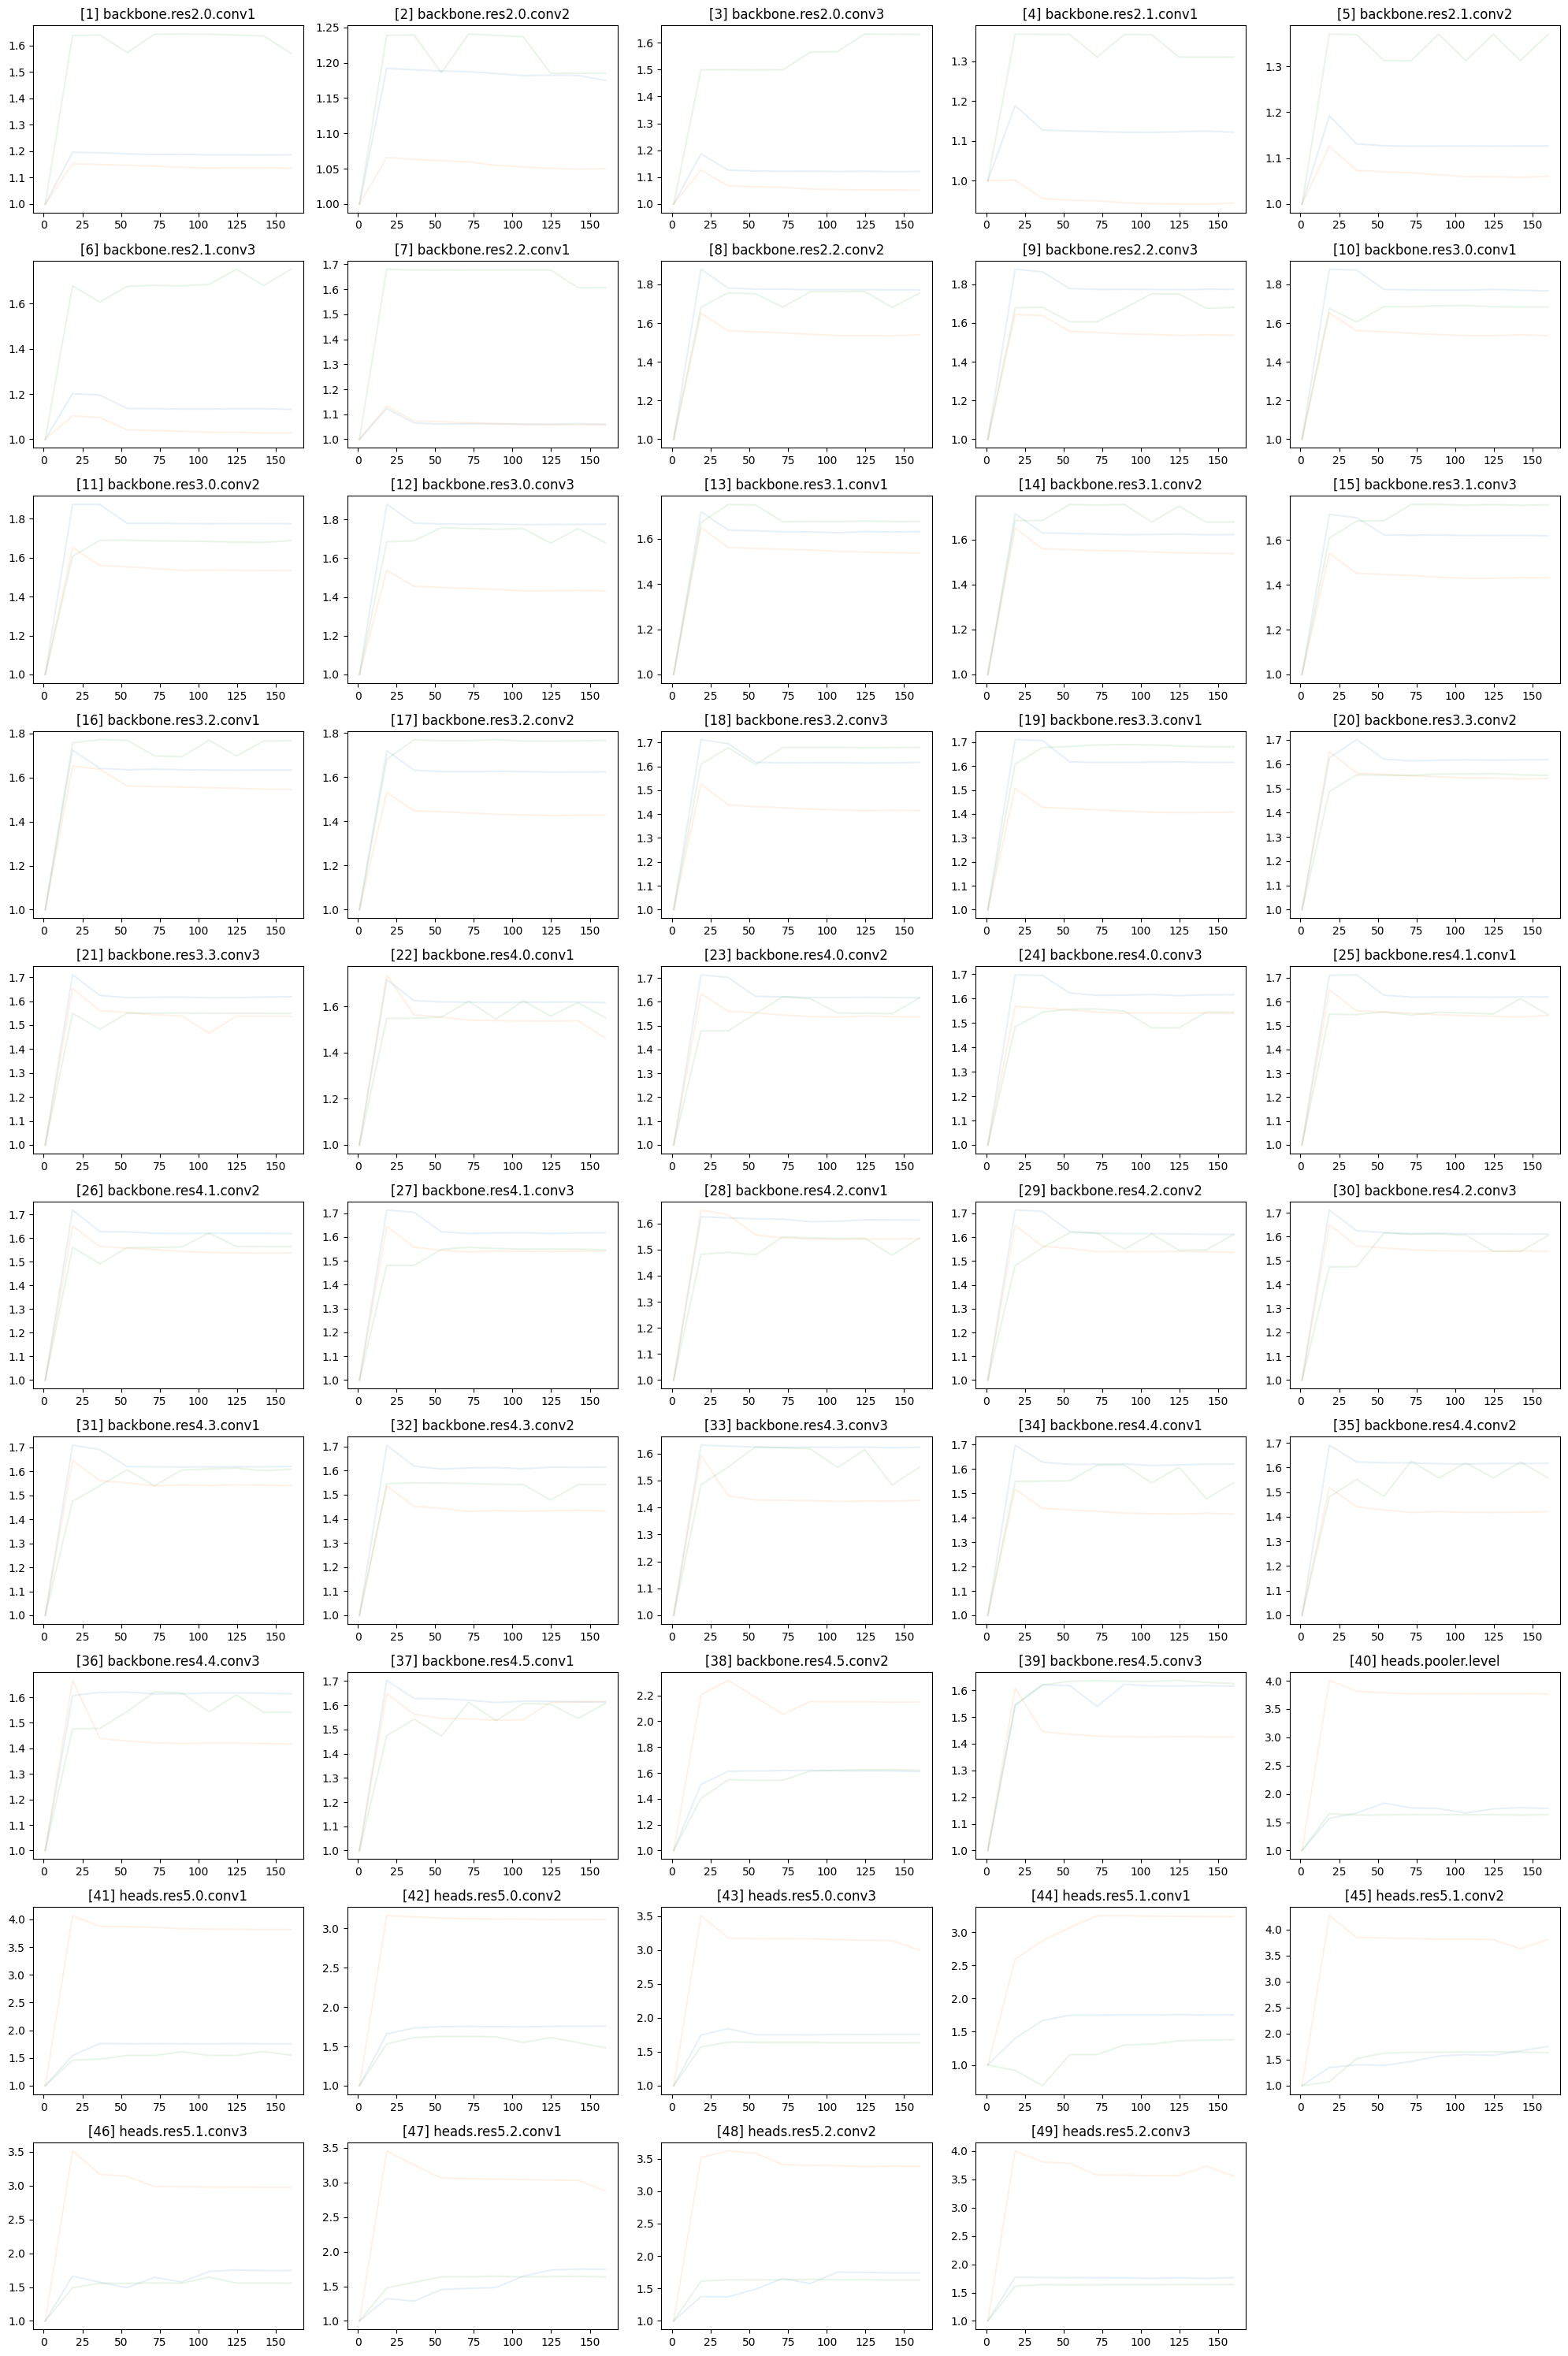

In [21]:
rows = 10
cols = 5
fig, axes = plt.subplots(rows,cols,figsize=(20,30))

layer_idx = 1

for i in range(rows):
    for j in range(cols):

        if layer_idx > len(layers): continue
        
        layer = layers[layer_idx-1]

        for img_idx,img in faithfulness_all[layer].items():
            axes[i,j].plot(np.asarray(sigma_all[layer][img_idx]), np.asarray(img)/img[0],alpha=0.1)

        axes[i,j].set_title(f"[{layer_idx}] {layer}")
        # axes[i,j].axis('off')
        layer_idx += 1

        # axes[i,j].set_xlabel('Value')
        # axes[i,j].set_ylabel('Frequency')

for i in range(layer_idx, rows * cols + 1):
    fig.delaxes(axes.flatten()[i - 1])

# plt.title('Sigma (By layer)')
plt.tight_layout()
plt.show()

### Absolute

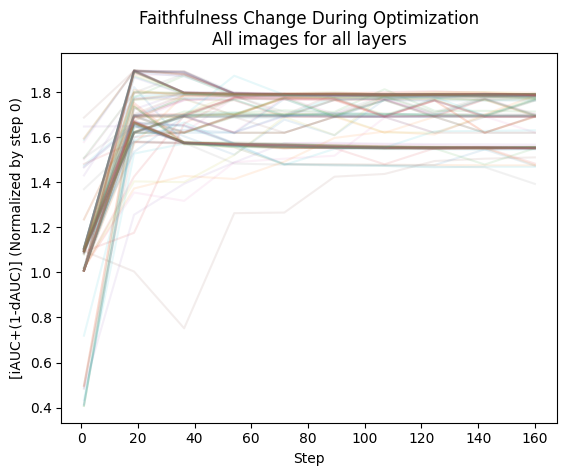

In [22]:
# Faithfulness Relative Value Distribution

for l, faithfulness_layer in faithfulness_all.items():
    if l not in layers:continue
    for i, img in faithfulness_layer.items():
        plt.plot(np.asarray(sigma_all[l][i]), np.asarray(img),alpha=0.1)
plt.xlabel('Step')
plt.ylabel('[iAUC+(1-dAUC)] (Normalized by step 0)')
plt.title('Faithfulness Change During Optimization\nAll images for all layers')
plt.show()

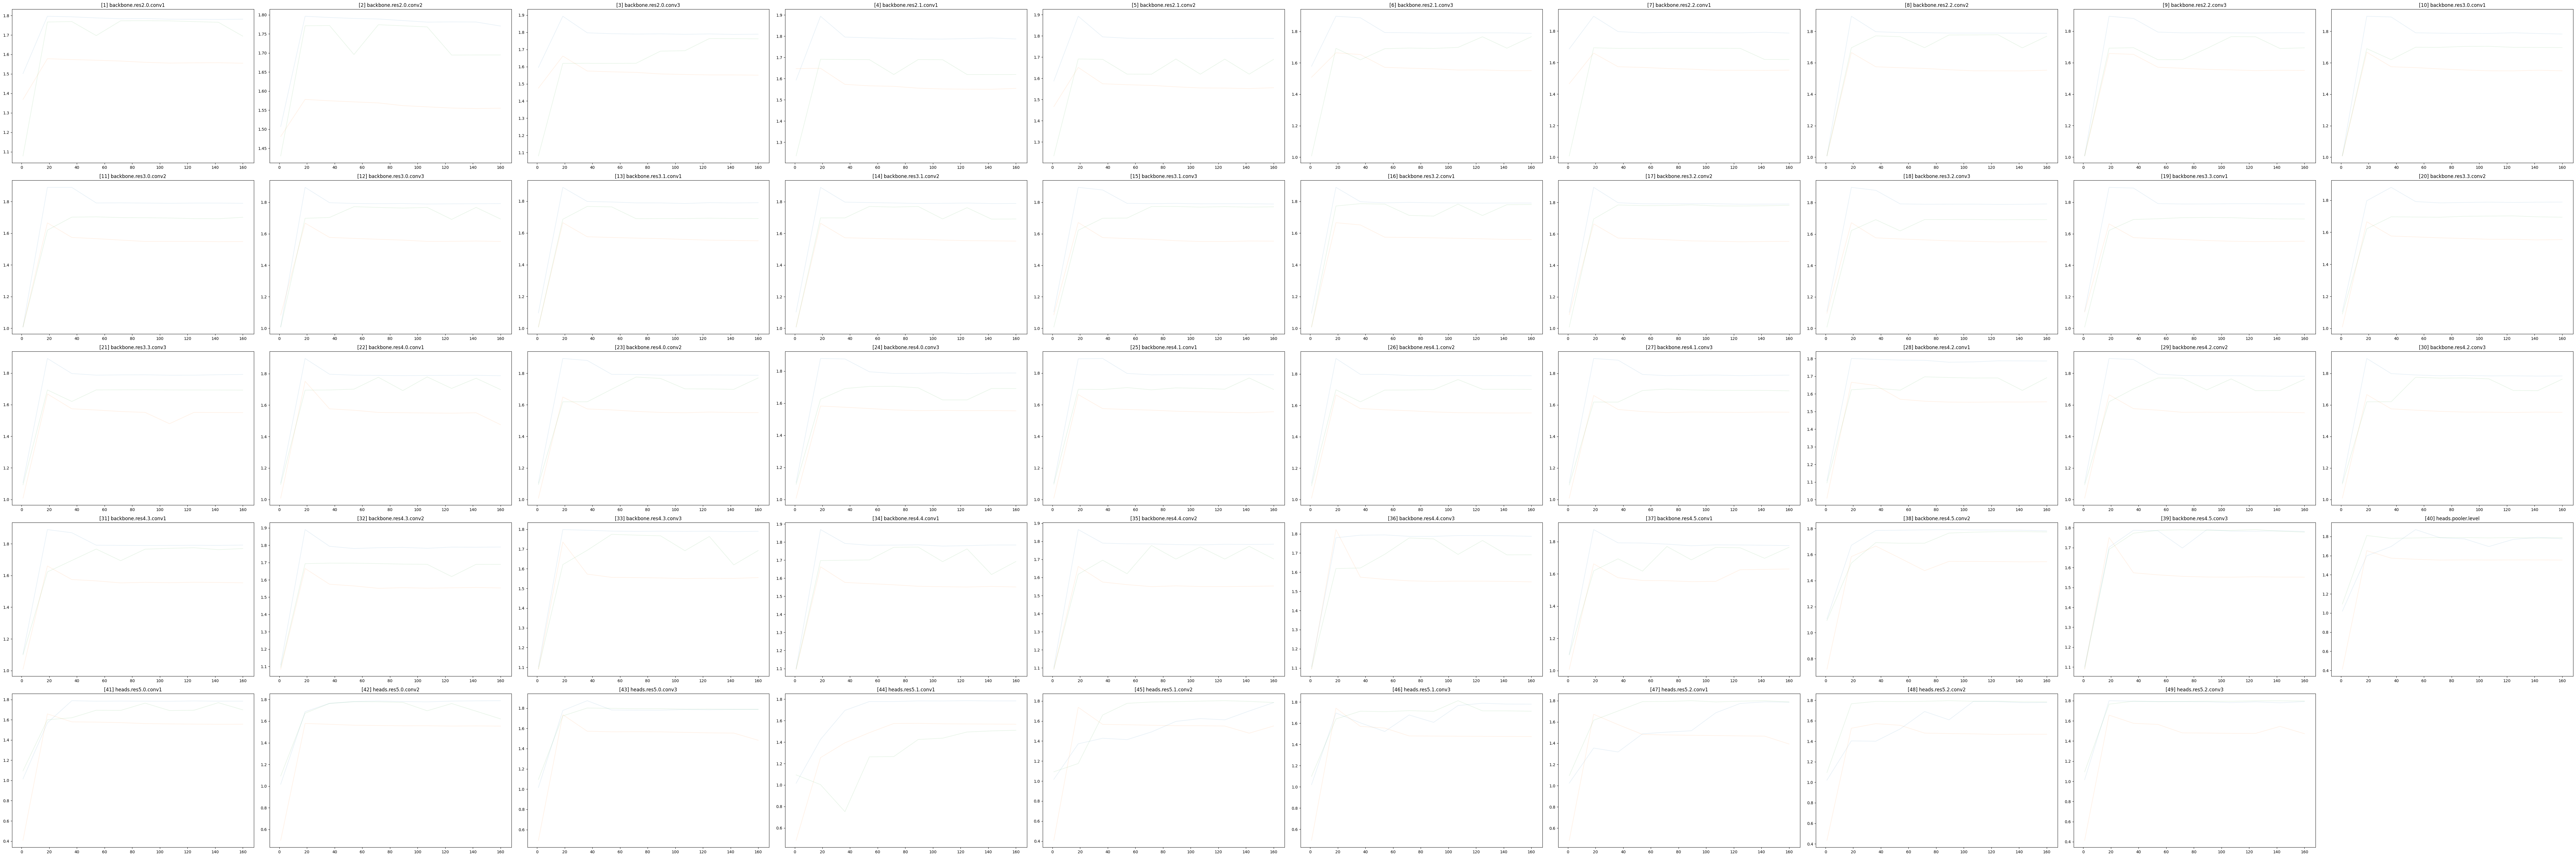

In [23]:
rows = 5
cols = 10
fig, axes = plt.subplots(rows,cols,figsize=(90,30))

layer_idx = 1

for i in range(rows):
    for j in range(cols):

        if layer_idx > len(layers): continue
        
        layer = layers[layer_idx-1]

        for img_idx,img in faithfulness_all[layer].items():
            axes[i,j].plot(np.asarray(sigma_all[layer][img_idx]),np.asarray(img),alpha=0.1)

        axes[i,j].set_title(f"[{layer_idx}] {layer}")
        # axes[i,j].axis('off')
        layer_idx += 1

        # axes[i,j].set_xlabel('Value')
        # axes[i,j].set_ylabel('Frequency')

for i in range(layer_idx, rows * cols + 1):
    fig.delaxes(axes.flatten()[i - 1])

# plt.title('Sigma (By layer)')
plt.tight_layout()
plt.savefig('/home/jinhanz/cs/xai/faithfulness_by_layer_absolute_sigma.png',dpi=600)